[Versión Interactiva](https://mybinder.org/v2/git/https%3A%2F%2Fgithub.com%2Fjuandadamo%2Fclases_fiuba/HEAD?filepath=6731%2Fdifusion-y-soluciones-numericas.ipynb)

In [1]:
!pip install future  ht fluids matplotlib numpy scipy

In [2]:
!pip install  fipy 

     |████████████████████████████████| 6.0 MB 1.5 MB/s eta 0:00:01
  Created wheel for fipy: filename=FiPy-3.4.2.1-py3-none-any.whl size=428095 sha256=ab68e0529dbcb3aead74a685a406f26c8d67de536e01cda35925199fa984dbb1
  Stored in directory: /home/juan/.cache/pip/wheels/88/c7/c7/d81adcb8e9574c321345f40384f69b3e2b366d755747555250
Successfully built fipy


In [86]:
from scipy.special import erf  
import numpy as np
import matplotlib.pyplot as plt
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer
from IPython.display import Latex
from matplotlib import lines
mk = [mki for mki in lines.Line2D.markers.keys()][2:]

## Solucion numerica del problema de difusión
### Conducción no estacionaria en tranferencia de calor

$$\frac{\partial T}{\partial t} = D \nabla^2 T.$$

### Caso 1: Problema sólido sometido a una condición inicial de Temperatura.

In [5]:
### Geometría
nx = 50
Lx = 30e-2
dx = Lx/nx
T0 = 10.
T1 = 20.
#Definicion de una malla
mesh = Grid1D(Lx=Lx, dx = dx)
#acceso a los nodos de la malla
x = mesh.cellCenters[0]

#Definición de la variable solución del problema: T
T = CellVariable(name="Temperatura",mesh=mesh, value=T0)

#Valor Inicial de la solución
T.setValue(T0)

#Parámetro Físico de la ecuacion: Difusión a
a = 0.27e-5  #ladrillo

# Condiciones de Borde Dirichlet 0 y 1
valueLeft = T1
valueRight = T0
# Condicion de Borde Neumann en 0
GradValueLeft = -1  #estos es qs/lambda

# Aplicacion sobre la variable solucion del problema
T.constrain(valueRight, mesh.facesRight)
T.constrain(valueLeft, mesh.facesLeft)
#T.faceGrad.constrain(-1,mesh.facesLeft)

El incremento de tiempo máximo admisible se estima $\Delta t \le \Delta x^2 / (2 a)$.
Una fracción de ese valor asegura que el cálculo numérico sea estable.



In [6]:
# Definicion de la variable tiempo
delta_tiempo = 0.5 * dx**2 / (2 * a)

# Horizonte de tiempo "corto"
Fourier = 0.035  # t *a / x
t_final = Fourier * Lx/a
pasos = np.int(t_final / delta_tiempo)

tiempo = np.linspace(0,t_final,pasos)

# Definición de la ecuación a resolver: Ecuacion de Fourier
# Se trata de un termino transitorio y un termino difusivo
# Se define un objeto ecuacion:    eqX
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff=a)  

#Opcional para este problema introductorio, comparación con el resultado analítico
T_Analytical_1 = CellVariable(name="Temperatura analítica", mesh=mesh)
T_Analytical_2 = CellVariable(name="Temperatura analítica", mesh=mesh)
# Evaluamos en el tiempo final
T_Analytical_1.setValue(T0+(T1-T0)*(1 - erf(x / (2 * np.sqrt(a * t_final))))) 
T_Analytical_2.setValue(T0+(T1-T0)*(1 - erf(x / (2 * np.sqrt(a * t_final/2))))) 
#T_Analytical.setValue(0 - GradValueLeft *( np.sqrt(4*a*t_final/np.pi)*np.exp(-x**2/(4*a*t_final))-x*(1-erf(x/(4*a*t_final)**.5) ) ) )

In [7]:
display(Latex('$\Delta t$=%.2g s'%delta_tiempo))
display(Latex('$T_{final}$=%.1f s'%t_final))
display(Latex('Pasos de tiempo: %0d'%tiempo.shape[0]))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
# Preparación de la salida gráfica. Se visualizará la solución y la referencia analítica
#viewer = Viewer(vars=(T,T_Analytical) )
perfil_temp = np.tile(np.zeros_like(T.value),(pasos,1))
# Resolución de la ecuación diferencial para cada paso temporal 
T.setValue(T0)
for i,tiempo_i in enumerate(tiempo):
    perfil_temp[i] = T.value
    eqX.solve(var=T,dt=delta_tiempo)
    #if __name__ == '__main__':
       # viewer.plot()#('1Dtransient_%0d.png'%step)
    

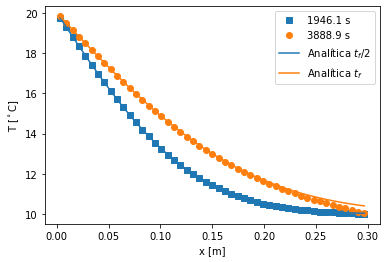

In [9]:
#Creamos un objeto para graficar: una figura y sus ejes
fig0,ax0  = plt.subplots()

#indice que corresponde a la mitad del tiempo final
i = np.abs(tiempo-t_final/2).argmin()

# plots sobre los ejes de los perfiles de temperatura calculados
lin1, = ax0.plot(x.value,perfil_temp[i],label='%.1f s'%tiempo[i],marker='s',linestyle='')
lin2, = ax0.plot(x.value,perfil_temp[-1],label='%.1f s'%t_final,marker='o',linestyle = '')

# plots de los perfiles analíticos
ax0.plot(x.value,T_Analytical_2.value,label= r'Analítica $t_f/2$',color = lin1.get_color())
ax0.plot(x.value,T_Analytical_1.value,label= r'Analítica $t_f$',color = lin2.get_color())
ax0.legend()
ax0.set_xlabel('x [m]')
ax0.set_ylabel('T [$^\circ$C]');

### Caso 2: Problema sólido sometido a un flujo de calor constante.

In [10]:
### Geometría
nx = 50
Lx = 30e-2
dx = Lx/nx
T0 = 10.
T1 = 20.
#Definicion de una malla
mesh = Grid1D(Lx=Lx, dx = dx)
#acceso a los nodos de la malla
x = mesh.cellCenters[0]

#Definición de la variable solución del problema: T
T = CellVariable(name="Temperatura",mesh=mesh, value=T0)

#Valor Inicial de la solución
T.setValue(T0)

#Parámetro Físico de la ecuacion: Difusión a
a = 0.27e-5  #ladrillo

# Condiciones de Borde Dirichlet 0 y 1
valueRight = T0
# Condicion de Borde Neuman en 0
GradValueLeft = -20  #estos es qs/lambda

# Aplicacion sobre la variable solucion del problema
T.constrain(valueRight, mesh.facesRight)
T.faceGrad.constrain(GradValueLeft,mesh.facesLeft)

In [16]:
# Definicion de la variable tiempo
delta_tiempo = 0.5 * dx**2 / (2 * a)

# Horizonte de tiempo "corto"
Fourier = 0.035  # t *a / x
t_final = Fourier * Lx/a
pasos = np.int(t_final / delta_tiempo)

tiempo = np.linspace(0,t_final,pasos)

# Definición de la ecuación a resolver: Ecuacion de Fourier
# Se trata de un termino transitorio y un termino difusivo
# Se define un objeto ecuacion:    eqX
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff=a)  

#Opcional para este problema introductorio, comparación con el resultado analítico
T_Analytical = CellVariable(name="Temperatura analítica tf", mesh=mesh)
T_Analytical2 = CellVariable(name="Temperatura analítica tf/2", mesh=mesh)
# Evaluamos en el tiempo final
T_Analytical.setValue(T0 - GradValueLeft *( np.sqrt(4*a*t_final/np.pi)*np.exp(-x**2/(4*a*t_final))-x*(1-erf(x/(4*a*t_final)**.5) ) ) )
T_Analytical2.setValue(T0 - GradValueLeft *( np.sqrt(4*a*t_final/2/np.pi)*np.exp(-x**2/(4*a*t_final/2))-x*(1-erf(x/(4*a*t_final/2)**.5) ) ) )

In [12]:
# Preparación de la salida gráfica. Se visualizará la solución y la referencia analítica
#viewer = Viewer(vars=(T,T_Analytical) )
perfil_temp2 = np.tile(np.zeros_like(T.value),(pasos,1))
# Resolución de la ecuación diferencial para cada paso temporal 
T.setValue(T0)
for i,tiempo_i in enumerate(tiempo):
    perfil_temp2[i] = T.value
    eqX.solve(var=T,dt=delta_tiempo)

    

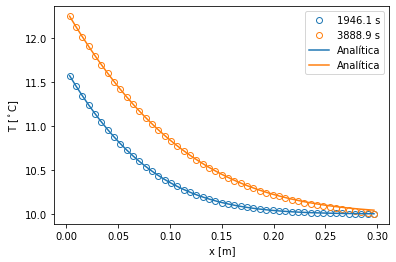

In [17]:
fig1,ax1  = plt.subplots()

i = np.abs(tiempo-t_final/2).argmin()
lin1, = ax1.plot(x.value,perfil_temp2[i],label='%.1f s'%tiempo[i],marker='o',linestyle='',markerfacecolor='None')
lin2, = ax1.plot(x.value,perfil_temp2[-1],label='%.1f s'%t_final,marker='o',linestyle='',markerfacecolor='None')
ax1.plot(x.value,T_Analytical2.value,label= r'Analítica',color = lin1.get_color())
ax1.plot(x.value,T_Analytical.value,label= r'Analítica',color = lin2.get_color())

ax1.legend()
ax1.set_xlabel('x [m]')
ax1.set_ylabel('T [$^\circ$C]');

### Caso 3: Problema sólido sometido a un pulso de energía

In [107]:
### Geometría
nx = 200
Lx = 30e-2
dx = Lx/nx
T0 = 10.
T1 = 20.
#Definicion de una malla
mesh = Grid1D(Lx=Lx, dx = dx)
#acceso a los nodos de la malla
x = mesh.cellCenters[0]

#Definición de la variable solución del problema: T
T = CellVariable(name="Temperatura",mesh=mesh, value=T0)

#Valor Inicial de la solución
T.setValue(T0)

#Parámetro Físico de la ecuacion: Difusión a
a = 0.27e-5  #ladrillo

# Condiciones de Borde Dirichlet 0 y 1
valueRight = T0

# Aplicacion sobre la variable solucion del problema
T.constrain(valueRight, mesh.facesRight)
time = Variable()
ValueLeft = T0+20*np.exp(-1*time) 
T.constrain(ValueLeft,mesh.facesLeft)

In [110]:
# Definicion de la variable tiempo
delta_tiempo = 0.1 * dx**2 / (2 * a)

# Horizonte de tiempo "corto"
Fourier = 0.035  # t *a / x
t_final = Fourier * Lx**2/a *50
pasos = np.int(t_final / delta_tiempo)



# Definición de la ecuación a resolver: Ecuacion de Fourier
# Se trata de un termino transitorio y un termino difusivo
# Se define un objeto ecuacion:    eqX
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff=a)  

#Opcional para este problema introductorio, comparación con el resultado analítico
T_Analytical = CellVariable(name="Temperatura analítica tf", mesh=mesh)
T_Analytical2 = CellVariable(name="Temperatura analítica tf/2", mesh=mesh)
# Evaluamos en el tiempo final


In [111]:
# Preparación de la salida gráfica. Se visualizará la solución y la referencia analítica
#viewer = Viewer(vars=(T,T_Analytical) )
perfil_temp2 = np.tile(np.zeros_like(T.value),(pasos,1))
# Resolución de la ecuación diferencial para cada paso temporal 
T.setValue(T0)
for i,tiempo_i in enumerate(tiempo):
    time.setValue(time() + delta_tiempo)
    perfil_temp2[i] = T.value
    eqX.solve(var=T,dt=delta_tiempo)

ifinal = i    

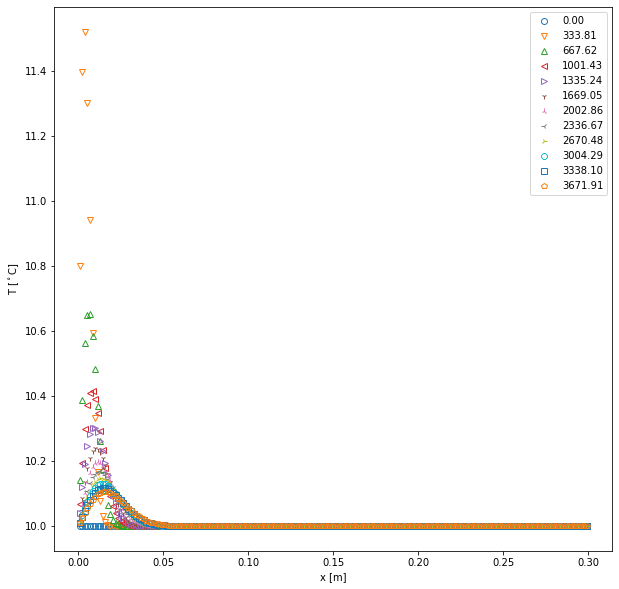

In [104]:
fig1,ax1  = plt.subplots(figsize=(10,10))

for i,tiempoi in enumerate(tiempo[::100]):
    lin1, = ax1.plot(x.value,perfil_temp2[i*100],label=f'{tiempoi:.2f}',marker=mk[i],linestyle='',markerfacecolor='None')


ax1.legend()
#ax1.set_xlim([0,0.05])
ax1.set_xlabel('x [m]')
ax1.set_ylabel('T [$^\circ$C]');